# Fitting of NIS tunneling spectroscopy measurments

In [1]:
import re

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyusadel import (
    UsadelProblem,
    fit_nis,
    resize_linspace,
    thermal_broadening,
    trivial_diffops,
)
from tqdm.notebook import tqdm

In [2]:
k_B = 86.17e-6

In [3]:
def add_label(ax, text, position="tl", color=[1, 1, 1, 0.90]):
    if position == "tl":
        ax.text(
            0.03,
            0.96,
            text,
            horizontalalignment="left",
            verticalalignment="top",
            fontsize=8,
            transform=ax.transAxes,
            bbox=dict(boxstyle="square", facecolor=color, linewidth=0, pad=0.20),
        )
    elif position == "tr":
        ax.text(
            0.65,
            0.96,
            text,
            horizontalalignment="left",
            verticalalignment="top",
            fontsize=8,
            transform=ax.transAxes,
            bbox=dict(boxstyle="square", facecolor=color, linewidth=0, pad=0.20),
        )
    elif position == "bl":
        ax.text(
            0.03,
            0.1,
            text,
            horizontalalignment="left",
            verticalalignment="top",
            fontsize=8,
            transform=ax.transAxes,
            bbox=dict(boxstyle="square", facecolor=color, linewidth=0, pad=0.20),
        )
    elif position == "br":
        ax.text(
            0.65,
            0.1,
            text,
            horizontalalignment="left",
            verticalalignment="top",
            fontsize=8,
            transform=ax.transAxes,
            bbox=dict(boxstyle="square", facecolor=color, linewidth=0, pad=0.20),
        )
    else:
        pass

In [4]:
def plot_cut(v_ax, g_exp, Delta, h, tau_sf_inv, tau_so_inv, x_N, T, Gamma, G_N):

    up = UsadelProblem(
        Nsites=1,
        diff_ops=trivial_diffops(),
        h_x=np.array([0.0]) + h,
        h_y=np.array([0.0]),
        h_z=np.array([0.0]),
        tau_sf_inv=np.array([0.0]) + tau_sf_inv,
        tau_so_inv=np.array([0.0]) + tau_so_inv,
        D=0,
        T=T,
        Gamma=Gamma,
    )

    up.Delta = np.array([Delta])

    up.set_real_omega_ax(-2.05, 2.05, 701)
    up.solve_spectral()

    DOS_fit = thermal_broadening(
        up.get_omega_ax_r(), G_N * ((1 - x_N) * up.get_ldos()[:, 0] + x_N), T
    )
    DOS_fitu = thermal_broadening(
        up.get_omega_ax_r(), G_N * up.get_spin_resolved_ldos("x")[0][:, 0], T
    )
    DOS_fitd = thermal_broadening(
        up.get_omega_ax_r(), G_N * up.get_spin_resolved_ldos("x")[1][:, 0], T
    )

    #############################

    # Plot the fitting together with the experimental data

    fig, ax = plt.subplots(figsize=(6, 4))
    ax.hlines([G_N], -2, 2, "k", linestyles="--", linewidths=0.5)
    ax.plot(up.get_omega_ax_r(), DOS_fit, "-", label=r"$G_\mathrm{fit}$")
    ax.plot(
        up.get_omega_ax_r(),
        DOS_fitu,
        "-",
        linewidth=0.5,
        label=r"$G_{\mathrm{fit} \uparrow}$",
    )
    ax.plot(
        up.get_omega_ax_r(),
        DOS_fitd,
        "--",
        linewidth=0.5,
        label=r"$G_{\mathrm{fit} \downarrow}$",
    )
    ax.plot(
        v_ax,
        g_exp,
        ".",
        markersize=4,
        label=r"$G_\mathrm{exp}$",
    )

    ax.set_xlabel(r"$V$ (meV)")
    ax.set_ylabel(r"$G$ ($2e^2/\hbar$)")

    fig.tight_layout()

In [5]:
map_file_url = "../exp_data/NIS_data/MDC004.Sample2/96.dat"

In [6]:
match = re.search(r"\.(\w+)", map_file_url)
sample_name = match.group(1)

match = re.search(r"/(\d+)\.dat$", map_file_url)
RunID = match.group(1)

fit_result_url = f"./fitting_results/MDC004_{sample_name}_RunID_{RunID}_lockin6_C_fit"

# Load data

In [7]:
# Import the dataset
data = pd.read_table(map_file_url)
data

,magnet_bpar,v_bias,lockin_6_CondX
0,-0.25,-0.00200,0.219277
1,-0.25,-0.00198,0.219462
2,-0.25,-0.00196,0.218969
3,-0.25,-0.00194,0.216723
4,-0.25,-0.00192,0.213092
...,...,...,...
40396,0.25,0.00192,0.224293
40397,0.25,0.00194,0.224631
40398,0.25,0.00196,0.223185
40399,0.25,0.00198,0.221769


In [8]:
# Extract the data from the dataset
v_N = data["magnet_bpar"].value_counts()[0]
b_N = data["v_bias"].value_counts()[0]

b = (
    data.pivot(columns="v_bias", index="magnet_bpar", values="magnet_bpar").to_numpy()
    * 1e3
)
_v = data.pivot(columns="v_bias", index="magnet_bpar", values="v_bias").to_numpy() * 1e3

g = data.pivot(
    columns="v_bias", index="magnet_bpar", values="lockin_6_CondX"
).to_numpy()

b_ax = b[:, 0]
_v_ax = _v[0, :]

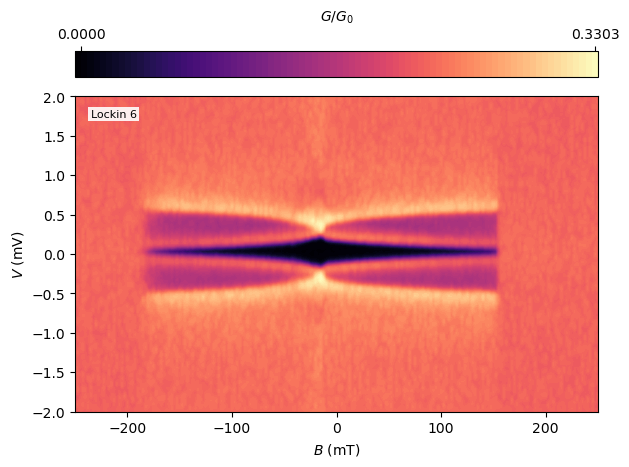

In [9]:
# Plot the data
fig, (ax1) = plt.subplots()
im1 = ax1.contourf(b, _v, g, levels=100, cmap="magma")
add_label(ax1, "Lockin 6")
cbar1 = plt.colorbar(im1, ax=ax1, location="top")
cbar1.set_ticks([0, g.max()])

ax1.set_ylabel(r"$V$ (mV)")
ax1.set_xlabel(r"$B$ (mT)")
cbar1.set_label(r"$G/G_0$")

fig.tight_layout()

# Compensation of the voltage offset

In [89]:
# Sample 12

# RunID_15, RunID_16
# v_offset = +0.042

# RunID_39, RunID_40
# v_offset = -0.054

# RunID_77
# v_offset = +0.010


# Sample A4

# RunID_96, RunID_97
v_offset = +0.038

# RunID_28, RunID_29
# v_offset = +0.056

In [90]:
v_ax = _v_ax - v_offset
v = _v - v_offset

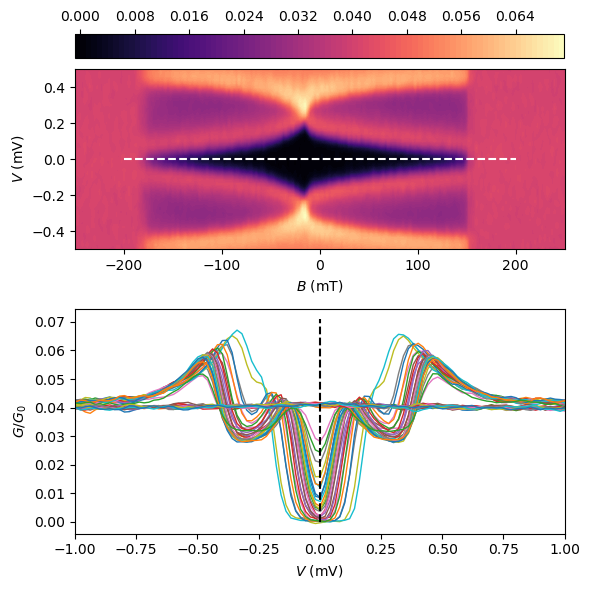

In [91]:
# Plot the data
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(6, 6))
im1 = ax1.contourf(b, v, g, levels=100, cmap="magma")
sbar1 = plt.colorbar(im1, ax=ax1, location="top")

ax1.hlines([0], -200, 200, "w", linestyles="--")
ax1.set_ylim(-0.5, 0.5)

ax2.plot(v_ax, g[0:b_N:5].T, linewidth=1)
ax2.vlines([0], -0, g.max(), "k", linestyles="--")

ax2.set_xlim(-1, 1)
# ax2.set_ylim(-0.02, 100)

ax1.set_ylabel(r"$V$ (mV)")
ax1.set_xlabel(r"$B$ (mT)")
cbar1.set_label(r"$G/G_0$")

ax2.set_ylabel(r"$G/G_0$")
ax2.set_xlabel(r"$V$ (mV)")


fig.tight_layout()

# Fitting of G_N

In [92]:
# Sample 1

# RunID 15, 16
# v_min, v_max = 0.75, 2
# b_min, b_max = 100, 250

# RunID 39
# b_min, b_max = 50, 100

# RunID  40
# b_min, b_max = -100, -50

# RunID 77
# v_min, v_max = 0.50, 2
# b_min, b_max = -100, -75


# Sample 2

# RunID 96
v_min, v_max = 0.50, 2
b_min, b_max = 170, 250

# RunID 97
# b_min, b_max = -200, -170

In [93]:
v_min_idx, v_max_idx = np.argmin(np.abs(v_ax - v_min)), np.argmin(np.abs(v_ax - v_max))
b_min_idx, b_max_idx = np.argmin(np.abs(b_ax - b_min)), np.argmin(np.abs(b_ax - b_max))

v_min, v_max = v_ax[[v_min_idx, v_max_idx]]
b_min, b_max = b_ax[[b_min_idx, b_max_idx]]

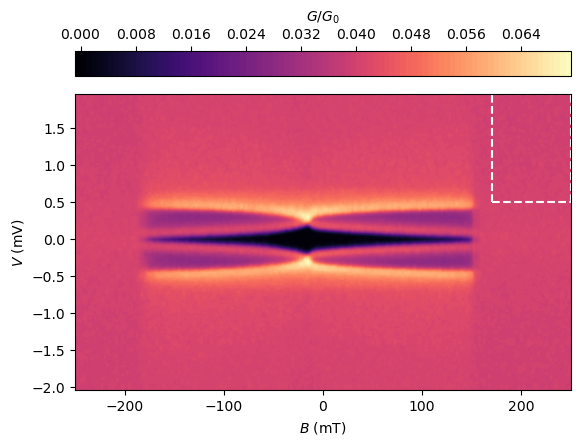

In [94]:
# Plot the data
fig, ax1 = plt.subplots(ncols=1, sharey=True)
im1 = ax1.contourf(b, v, g, levels=100, cmap="magma")
cbar1 = plt.colorbar(im1, ax=ax1, location="top")

ax1.hlines([v_min, v_max], b_min, b_max, "w", linestyles="--")
ax1.vlines([b_min, b_max], v_min, v_max, "w", linestyles="--")

ax1.set_ylabel(r"$V$ (mV)")
ax1.set_xlabel(r"$B$ (mT)")
cbar1.set_label(r"$G/G_0$")

In [95]:
G_N = np.mean(g[b_min_idx:b_max_idx, v_min_idx:v_max_idx])
Sigma_GN = np.var(g[b_min_idx:b_max_idx, v_min_idx:v_max_idx])

print(f"G_N = {G_N:3.2f}")
print(f"Sigma_GN = {Sigma_GN:3.2f}")

G_N = 0.04
Sigma_GN = 0.00


In [96]:
Gamma = 1e-6
Sigma_Gamma = 0.0

print(f"Gamma = {Gamma:3.2e}")
print(f"Sigma_Gamma = {Sigma_Gamma:3.2e}")

Gamma = 1.00e-06
Sigma_Gamma = 0.00e+00


# Extraction of x_N

In [97]:
v_zb = np.argmin(abs(v_ax))
g_zb = g[:, v_zb]

In [98]:
x_N = g_zb / G_N
x_N = x_N.clip(0, 1)

Text(0.5, 0, '$B$ (mT)')

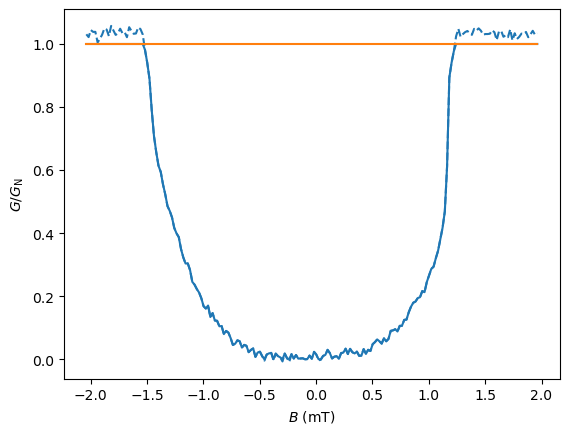

In [99]:
fig, ax = plt.subplots()

ax.plot(v_ax, x_N)
ax.plot(v_ax, g_zb / G_N, "--C0")
ax.plot(v_ax, v_ax * 0 + 1)

ax.set_ylabel(r"$G / G_\mathrm{N}$")
ax.set_xlabel(r"$B$ (mT)")

# Set the temperature

In [100]:
T = 40 * k_B

In [101]:
# Sample 12

# RunID_15
# b_min, b_max, b_start = -84, 54, -5  # -12

# RunID_16
# b_min, b_max, b_start = -54, 84, 12

# RunID 39
# b_min, b_max, b_start = -80, 44, -12

# RunID 40
# b_min, b_max, b_start = -42, 80, +12

# RunID 77
# b_min, b_max, b_start = -70, 100, +15

# Sample A4

# RunID 96 g_1, g_2
b_min, b_max, b_start = -190, 160, -15

# RunID 97 g1, g2
# b_min, b_max, b_start = -160, 190, +15

# RunID 28 g1
# b_min, b_max, b_start = -185, 158, -15

# RunID 29 g1
# b_min, b_max, b_start = -158, 185, 15


b_min_idx, b_max_idx, b_start_idx = (
    np.argmin(np.abs(b_ax - b_min)),
    np.argmin(np.abs(b_ax - b_max)),
    np.argmin(np.abs(b_ax - b_start)),
)

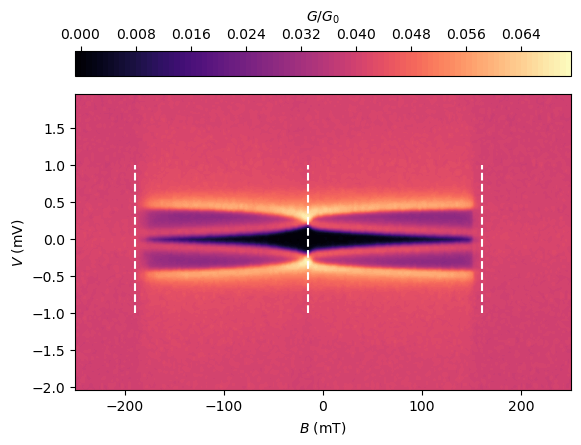

In [102]:
# Plot the data
fig, ax1 = plt.subplots(ncols=1, sharey=True)
im1 = ax1.contourf(b, v, g, levels=100, cmap="magma")
cbar1 = plt.colorbar(im1, ax=ax1, location="top")

ax1.vlines([b_min, b_start, b_max], -1, 1, "w", linestyles="--")

ax1.set_ylabel(r"$V$ (mV)")
ax1.set_xlabel(r"$B$ (mT)")
cbar1.set_label(r"$G/G_0$")

# Fitting

In [103]:
popt = np.zeros((b_N, 4))
pcov = np.zeros((b_N, 4, 4))
fits = np.zeros((b_N, v_N))

In [104]:
params = dict(
    Delta=[0.00, 0.250, 0.400],
    h=[0.00, 0.001, 0.350],
    G_N=G_N,
    T=T,
    tau_sf_inv=[0.00, 0.1, 0.2],
    tau_so_inv=[0.00, 0.1, 0.2],
    Gamma=Gamma,
    x_N=0,
)

In [105]:
idxs = list(range(b_start_idx, b_max_idx))

for i in tqdm(idxs):

    params["x_N"] = x_N[i]

    _popt, _pcov = fit_nis(
        e_ax_exp=v_ax,
        dos_exp=g[i],
        **params,
        verbose=False,
        tol=1e-7,
    )
    popt[i] = _popt
    pcov[i] = _pcov
    initial_guess = _popt

    Delta, h, tau_sf_inv, tau_so_inv = _popt

    params["Delta"][1] = Delta
    params["h"][1] = h
    params["tau_sf_inv"][1] = tau_sf_inv
    params["tau_so_inv"][1] = tau_so_inv

    print(
        f"""B={b_ax[i]:3.1f}: Delta = {Delta:5.4f}, h = {h:5.4f}, """
        f"""tau_sf_inv = {tau_sf_inv:5.4f}, tau_so_inv = {tau_so_inv:5.4f}"""
    )

  0%|          | 0/70 [00:00<?, ?it/s]

B=-15.0: Delta = 0.2718, h = 0.0218, tau_sf_inv = 0.0275, tau_so_inv = 0.0000
B=-12.5: Delta = 0.2770, h = 0.0346, tau_sf_inv = 0.0292, tau_so_inv = 0.0000
B=-10.0: Delta = 0.2774, h = 0.0567, tau_sf_inv = 0.0325, tau_so_inv = 0.0120
B=-7.5: Delta = 0.2805, h = 0.0660, tau_sf_inv = 0.0315, tau_so_inv = 0.0117
B=-5.0: Delta = 0.2762, h = 0.0763, tau_sf_inv = 0.0348, tau_so_inv = 0.0270
B=-2.5: Delta = 0.2754, h = 0.0794, tau_sf_inv = 0.0324, tau_so_inv = 0.0240
B=0.0: Delta = 0.2758, h = 0.0842, tau_sf_inv = 0.0320, tau_so_inv = 0.0318
B=2.5: Delta = 0.2787, h = 0.0880, tau_sf_inv = 0.0307, tau_so_inv = 0.0234
B=5.0: Delta = 0.2775, h = 0.0916, tau_sf_inv = 0.0387, tau_so_inv = 0.0157
B=7.5: Delta = 0.2749, h = 0.0946, tau_sf_inv = 0.0364, tau_so_inv = 0.0287
B=10.0: Delta = 0.2754, h = 0.0979, tau_sf_inv = 0.0357, tau_so_inv = 0.0250
B=12.5: Delta = 0.2753, h = 0.1003, tau_sf_inv = 0.0342, tau_so_inv = 0.0313
B=15.0: Delta = 0.2761, h = 0.1033, tau_sf_inv = 0.0344, tau_so_inv = 0.0313


In [106]:
params = dict(
    Delta=[0.00, popt[b_start_idx + 1][0], 0.400],
    h=[0.00, popt[b_start_idx + 1][1], 0.350],
    G_N=G_N,
    T=T,
    tau_sf_inv=[0.00, popt[b_start_idx + 1][2], 0.2],
    tau_so_inv=[0.00, popt[b_start_idx + 1][3], 0.2],
    Gamma=Gamma,
    x_N=0,
)

In [107]:
idxs = list(range(b_start_idx, b_min_idx, -1))

for i in tqdm(idxs):

    params["x_N"] = x_N[i]

    _popt, _pcov = fit_nis(
        e_ax_exp=v_ax,
        dos_exp=g[i],
        **params,
        verbose=False,
        tol=1e-7,
    )
    popt[i] = _popt
    pcov[i] = _pcov
    initial_guess = _popt

    Delta, h, tau_sf_inv, tau_so_inv = _popt

    params["Delta"][1] = Delta
    params["h"][1] = h
    params["tau_sf_inv"][1] = tau_sf_inv
    params["tau_so_inv"][1] = tau_so_inv

    print(
        f"""B={b_ax[i]:3.1f}: Delta = {Delta:5.4f}, h = {h:5.4f}, """
        f"""tau_sf_inv = {tau_sf_inv:5.4f}, tau_so_inv = {tau_so_inv:5.4f}"""
    )

  0%|          | 0/70 [00:00<?, ?it/s]

B=-15.0: Delta = 0.2742, h = 0.0264, tau_sf_inv = 0.0247, tau_so_inv = 0.0198
B=-17.5: Delta = 0.2719, h = 0.0216, tau_sf_inv = 0.0280, tau_so_inv = 0.0000
B=-20.0: Delta = 0.2744, h = 0.0305, tau_sf_inv = 0.0277, tau_so_inv = 0.0000
B=-22.5: Delta = 0.2765, h = 0.0377, tau_sf_inv = 0.0280, tau_so_inv = 0.0137
B=-25.0: Delta = 0.2750, h = 0.0447, tau_sf_inv = 0.0353, tau_so_inv = 0.0002
B=-27.5: Delta = 0.2730, h = 0.0559, tau_sf_inv = 0.0321, tau_so_inv = 0.0278
B=-30.0: Delta = 0.2776, h = 0.0604, tau_sf_inv = 0.0327, tau_so_inv = 0.0128
B=-32.5: Delta = 0.2768, h = 0.0672, tau_sf_inv = 0.0394, tau_so_inv = 0.0020
B=-35.0: Delta = 0.2730, h = 0.0741, tau_sf_inv = 0.0350, tau_so_inv = 0.0208
B=-37.5: Delta = 0.2755, h = 0.0783, tau_sf_inv = 0.0363, tau_so_inv = 0.0190
B=-40.0: Delta = 0.2745, h = 0.0849, tau_sf_inv = 0.0410, tau_so_inv = 0.0065
B=-42.5: Delta = 0.2734, h = 0.0911, tau_sf_inv = 0.0406, tau_so_inv = 0.0270
B=-45.0: Delta = 0.2742, h = 0.0949, tau_sf_inv = 0.0393, tau_so

In [108]:
keys = ("Delta", "h", "tau_sf_inv", "tau_so_inv")

popt_df = pd.DataFrame(popt, columns=keys, index=b_ax)
popt_df.index.name = "B"

popt_df["Sigma_D_D"] = pcov[:, 0, 0]
popt_df["Sigma_D_h"] = pcov[:, 0, 1]
popt_df["Sigma_D_tsf"] = pcov[:, 0, 2]
popt_df["Sigma_D_tso"] = pcov[:, 0, 3]
popt_df["Sigma_h_h"] = pcov[:, 1, 1]
popt_df["Sigma_h_tsf"] = pcov[:, 1, 2]
popt_df["Sigma_h_tso"] = pcov[:, 1, 3]
popt_df["Sigma_tsf_tsf"] = pcov[:, 2, 2]
popt_df["Sigma_tsf_tso"] = pcov[:, 2, 3]
popt_df["Sigma_tso_tso"] = pcov[:, 3, 3]

popt_df["x_N"] = x_N
popt_df["G_N"] = G_N
popt_df["Sigma_GN"] = Sigma_GN

popt_df["Gamma"] = Gamma
popt_df["Sigma_Gamma"] = Sigma_Gamma

popt_df["T"] = T

# popt_df.to_csv(fit_result_url + ".csv")

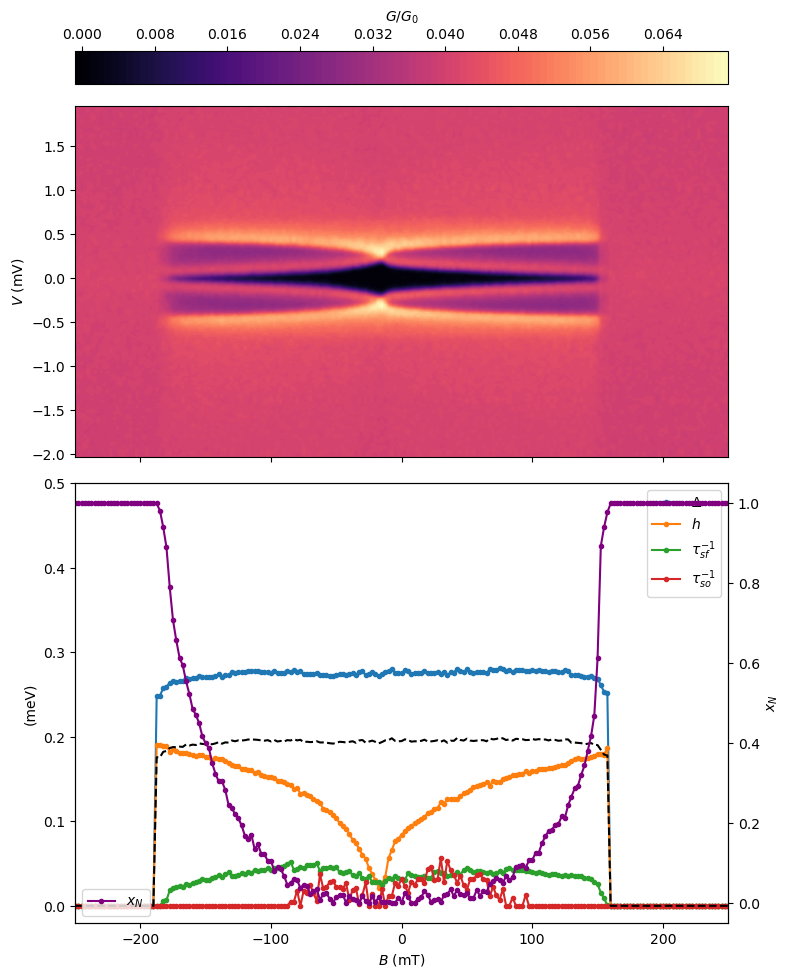

In [110]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(8, 10))

im1 = ax1.contourf(b, v, g, levels=100, cmap="magma")
cbar1 = plt.colorbar(im1, ax=ax1, location="top")
ax1.set_ylabel(r"$V$ (mV)")
cbar1.set_label(r"$G/G_0$")

ax2.plot(b_ax, popt[:, 0], ".-", label=r"$\Delta$")
ax2.plot(b_ax, popt[:, 1], ".-", label=r"$h$")
ax2.plot(b_ax, popt[:, 2], ".-", label=r"$\tau_{sf}^{-1}$")
ax2.plot(b_ax, popt[:, 3], ".-", label=r"$\tau_{so}^{-1}$")
ax2.plot(b_ax, popt[:, 0] / np.sqrt(2), "--k")

ax2.set_ylabel("(meV)")
ax2.set_xlabel(r"$B$ (mT)")
ax2.set_ylim(-0.02, 0.5)
ax2.legend()

ax2b = ax2.twinx()
ax2b.plot(b_ax, x_N, ".-", color="purple", label=r"$x_N$")
ax2b.set_ylabel(r"$x_N$")
ax2b.legend()

fig.tight_layout()